In [4]:
# %%HTML
# <style>
#     body {
#         --vscode-font-family: "Verdana"
#     }
# </style>

# #ComicSansMS

# Intro
We aim to predict future GDP using time series analysis techniques.  
  
**ARIMA (Autoregressive Integrated Moving Average)**
**Formula**:
$$ X_t = \alpha + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} + \epsilon_t $$

Where:
- $X_t$: Value of the time series at time `t`.
- $\alpha$: Constant term.
- $\phi_1, \phi_2, ... , \phi_p$: Autoregressive parameters of order `p`.
- $\theta_1, \theta_2, ... , \theta_q$: Moving average parameters of order `q`.
- $\epsilon_t$: Error term at time `t`.

**Components**:  
  
1. **AR (Autoregressive)**: Represents the relationship between an observation and a number of lagged observations (previous time steps).
   - Order `p`: Number of lag observations included in the model.
   - Parameters: $\phi_1, \phi_2, ... , \phi_p$.

2. **I (Integrated)**: Refers to the number of differences (or the value of `d`) taken to make the time series stationary. It's the order of differencing.
   - For example, if `d=1`, it refers to first-order differencing.

3. **MA (Moving Average)**: Represents the relationship between an observation and a residual error from a moving average model applied to lagged observations.
   - Order `q`: Number of lagged forecast errors in the prediction equation.
   - Parameters: $\theta_1, \theta_2, ... , \theta_q$.

Thus, an ARIMA model is typically defined by three parameters: `(p, d, q)`.


## Time Series Analysis for Predicting Future GDP Steps:
1. Data Collection & Preprocessing
2. Exploratory Data Analysis (EDA)
3. Ensure Stationarity
4. Autocorrelation Analysis
5. Model Choice
6. Forecasting and Validation
7. Post-Forecast Analysis

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import skew, kurtosis
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Data Collection & Preprocessing:
## Data collection
Retrieve data from [U.S. Bureau of Economic Analysis](https://apps.bea.gov/iTable/?reqid=19&step=2&isuri=1&categories=survey) (Section 7 - Supplemental Tables).


In [20]:
# Load data
data_orignal = pd.read_excel("National Income and Product Accounts.xlsx", skiprows=5)
data_orignal = data_orignal.iloc[:,1:]
data_orignal.index = data_orignal.iloc[:,0]

## Data processing
Although our primary interest is the Gross Domestic Product, we will clean the entire dataset.


In [21]:
data_1 = data_orignal.copy()
# Rename "Unnamed" columns
cols = list(data_1.columns)
for i in range(1, len(cols)):
    if 'Unnamed' in cols[i]:
        cols[i] = cols[i-1]
data_1.columns = cols

# Adjust columns using first row values
data_1.columns = [str(col) + str(sub_col) if pd.notna(sub_col) else str(col) for col, sub_col in zip(data_1.columns, data_1.iloc[0,:])]
data_1 = data_1.iloc[1:11,1:]

# Cleaning and setting index
data_1.index = data_1.index.str.strip()
data_1 = data_1.transpose()
data_1["year"] = pd.to_numeric(data_1.index.str[:4])
data_1["yr_q"] = data_1.index
data_1.index = pd.to_datetime(data_1.index)

# Display data structure
display(data_1)


Unnamed: 1,Current dollars:,Gross domestic product,Gross national product,Personal income,Disposable personal income,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,year,yr_q
1947-01-01,NaN,1699,1706,1325,1191,1091,668,145,523,423,1947,1947Q1
1947-04-01,NaN,1711,1718,1319,1184,1113,683,148,535,430,1947,1947Q2
1947-07-01,NaN,1728,1736,1369,1233,1132,695,151,544,437,1947,1947Q3
1947-10-01,NaN,1790,1798,1383,1240,1155,713,162,551,443,1947,1947Q4
1948-01-01,NaN,1824,1833,1417,1272,1169,721,162,560,448,1948,1948Q1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,NaN,76636,77242,64982,55508,52247,18044,6369,11675,34203,2022,2022Q2
2022-07-01,NaN,77875,78448,65964,56566,52979,18115,6420,11695,34863,2022,2022Q3
2022-10-01,NaN,79000,79556,66633,57372,53599,18091,6369,11723,35507,2022,2022Q4
2023-01-01,NaN,80126,80601,67666,59408,54595,18330,6559,11771,36265,2023,2023Q1


## **Exploratory Data Analysis (EDA)**:
- Visualize the data: Plot the GDP time series.
- Identify evident patterns, trends, or cyclic behaviors.


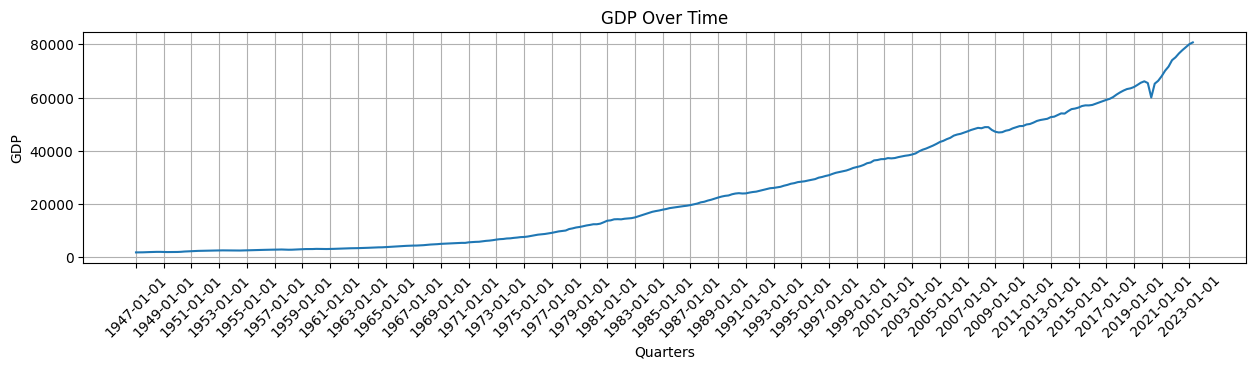

In [22]:
# Visualize GDP over time
plt.figure(figsize=(15, 3))
plt.plot(data_1["Gross domestic product"])   
plt.title("GDP Over Time")
plt.xlabel("Quarters")
plt.ylabel("GDP")
plt.xticks(data_1.index[::8], rotation=45)
plt.grid(True)
plt.show()

## **Ensure Stationarity**:
- Conduct stationarity tests, such as the Augmented Dickey-Fuller test.
- If the data is non-stationary, apply necessary transformations or differencing.

### Stationary Check
From a visual inspection of the growth rate graphs, both the GDP Growth Rate and its logarithmic transformation appear to be covariance-stationary. For a comprehensive conclusion, statistical tests are recommended.

#### Covariance-stationary Insights:
- **Mean Reversion**: Both series seem to gravitate around a consistent mean over time. Although deviations from this mean occur, such as the drop around 2020, the series invariably returns to the mean, indicating stationarity.
- **Constant Variance**: Both series exhibit fluctuations, but their amplitude remains relatively consistent, suggesting constant variance over time.
- **No Seasonality**: The series oscillates but does not show consistent repeating patterns, negating any seasonality.
- **4-Quarter Rolling Mean**: Represented by the red dashed line, it remains stable, reinforcing stationarity.
- **No Deterministic Trend**: Neither series has a consistent upward or downward trajectory, further implying stationarity.

From the above visual analysis, the GDP series appears non-stationary. To proceed with certain analyses, it's essential to transform the GDP data into a stationary format.


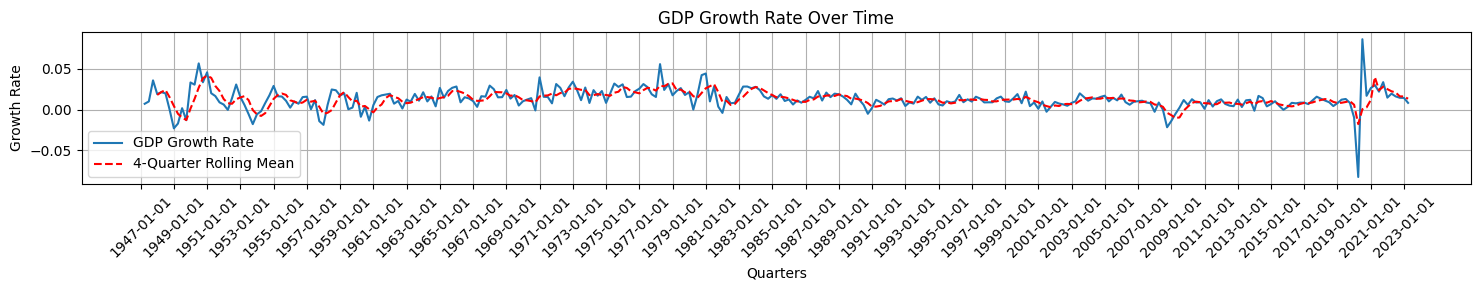

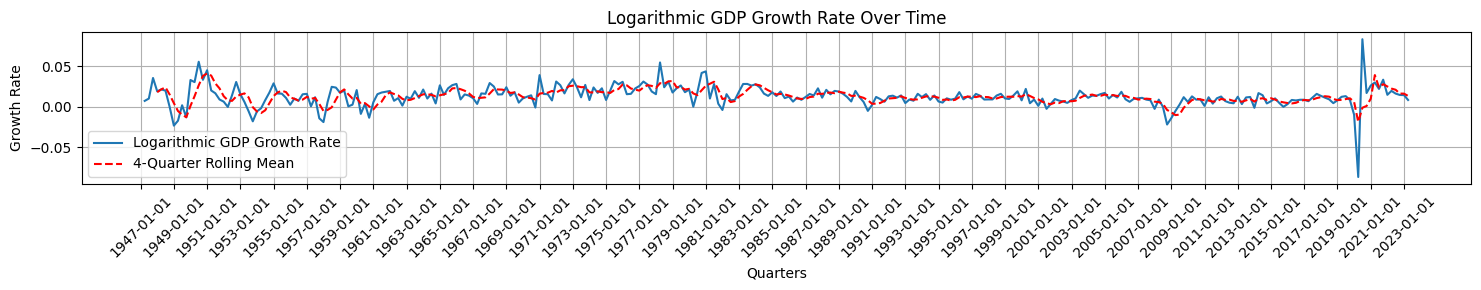

In [23]:
# Extract GDP data and calculate growth rates
gdp = data_1[["Gross domestic product", "year"]].dropna()
gdp["gdp_growth"] = gdp["Gross domestic product"].pct_change()
# Calculating the GDP growth rate
gdp_growth_log = [np.log(gdp["Gross domestic product"].values[i+1] / gdp["Gross domestic product"].values[i]) for i in range(len(gdp)-1)]
gdp_growth_log = [None] + gdp_growth_log  # Add a None value for the first entry because we don't have a growth rate for it

gdp["gdp_growth_log"] = gdp_growth_log

# Plotting regular and log GDP growth rates
for column, title in [("gdp_growth", "GDP Growth Rate"), ("gdp_growth_log", "Logarithmic GDP Growth Rate")]:
    plt.figure(figsize=(15, 3))
    plt.plot(gdp.index, gdp[column], label=title)
    plt.plot(gdp.index, gdp[column].rolling(4).mean(), linestyle="--", color="red", label="4-Quarter Rolling Mean")
    plt.title(f"{title} Over Time")
    plt.xlabel("Quarters")
    plt.ylabel("Growth Rate")
    plt.xticks(gdp.index[::8], rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Additional Statistical Measures

In [24]:
# Calculate and display key statistics
for column, label in [("gdp_growth", "GDP"), ("gdp_growth_log", "log GDP growth")]:
    print(f"{label} mean:", round(gdp[column].mean(),3))
    print(f"{label} std:", round(gdp[column].std(),3))
    print(f"{label} skew:", round(skew(gdp[column].dropna()),3))
    print(f"{label} kurt:", round(kurtosis(gdp[column].dropna()),3))
    print()

GDP mean: 0.013
GDP std: 0.013
GDP skew: -0.585
GDP kurt: 12.816

log GDP growth mean: 0.013
log GDP growth std: 0.013
log GDP growth skew: -0.874
log GDP growth kurt: 14.091



#### GDP Analysis Insights:
- **Mean**: Both the GDP growth and its log-transform exhibit an average of 1.3%.
- **Standard Deviation**: The GDP growth rates, both original and log-transformed, have a variability of 0.013.
- **Skewness**: GDP growth is left-skewed, especially its log-transform (-0.874), implying more instances of growth below the average.
- **Kurtosis**: Both datasets show high kurtosis, with the log-transformed set even higher at 14.091, indicating outliers.


## **Autocorrelation Analysis**:
### Plot ACF and PACF: 
Plot the (partial) autocorrelations for this process at lags 1 through 20 (i.e., 1 quarter to five years)

#### ACF vs PACF: Differences and Uses

##### **ACF (Autocorrelation Function)**
- **Definition**: ACF describes the autocorrelation between an observation and a lag of that observation in a time series.

###### **Uses**:
1. **Determining MA Order**: A sharp cutoff in the ACF suggests the need for MA terms.
2. **Identifying Seasonality**: Significant spikes at seasonal intervals in the ACF indicate seasonality.

##### **PACF (Partial Autocorrelation Function)**
- **Definition**: PACF provides the partial correlation of a time series with its own lags, accounting for the variations explained by the intervening observations.

###### **Uses**:
1. **Determining AR Order**: A sharp cutoff in the PACF suggests the need for AR terms.
2. **Identifying Direct Dependency**: PACF identifies the direct relationship between the observation and its lag.

In time series modeling, ACF and PACF plots are essential tools for determining the AR and MA orders in ARIMA models.


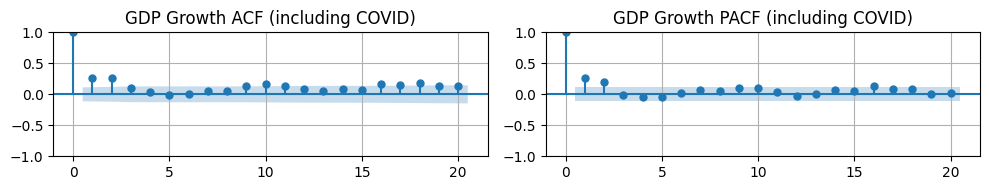

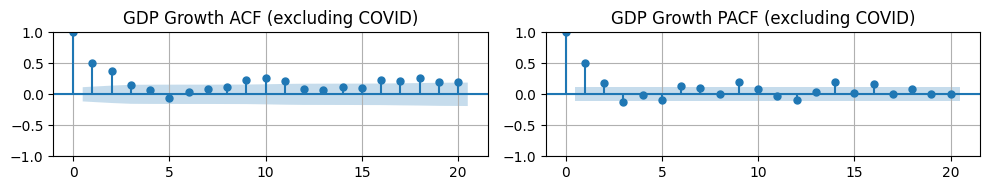

In [25]:
# Function to plot ACF and PACF for GDP growth
def plot_gdp_acf_pacf(data, title_suffix):
    """Plot ACF and PACF for given GDP data."""
    fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
    plot_acf(data['gdp_growth'].dropna(), lags=20, title=f"GDP Growth ACF ({title_suffix})", ax=ax)
    ax.grid(True)
    plot_pacf(data['gdp_growth'].dropna(), lags=20, title=f"GDP Growth PACF ({title_suffix})", ax=ax1)
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting ACF and PACF for the entire dataset
plot_gdp_acf_pacf(gdp, "including COVID")
plot_gdp_acf_pacf(gdp[gdp['year'] < 2020], "excluding COVID")

### ACF and PACF Interpretation

#### **General Insights**:
- Both ACF and PACF suggest an Autoregressive process in the data.
- An ARIMA model (or its variants) seems suitable for forecasting. Use the ACF and PACF plots to guide the order of the AR terms.


## **Model Choice**:
- Select a model based on data characteristics:
    - Consider ARIMA or SARIMA for GDP with seasonal patterns.
    - Exponential Smoothing for trended GDP.
    - Other models, such as Prophet or LSTM, for complex patterns.


Use only the training set

In [26]:
# Identifying the best ARIMA model based on AIC and BIC
orders = [(1,0,0), (2,0,0), (3,0,0), (1,0,1), (1,0,2), (1,0,3), (2,0,1), (2,0,2), (2,0,3)]
models, aic_values, bic_values = [], [], []

for order in orders:
    model = ARIMA(train['gdp_growth'].dropna(), order=order).fit()
    models.append(f'ARMA({order[0]},{order[2]})')
    aic_values.append(model.aic)
    bic_values.append(model.bic)

results = pd.DataFrame({'Models': models, 'AIC': aic_values, 'BIC': bic_values})
print(tabulate(results, headers='keys', tablefmt='grid'))

+----+-----------+----------+----------+
|    | Models    |      AIC |      BIC |
+====+===========+==========+==========+
|  0 | ARMA(1,0) | -1786.85 | -1775.7  |
+----+-----------+----------+----------+
|  1 | ARMA(2,0) | -1797.75 | -1782.9  |
+----+-----------+----------+----------+
|  2 | ARMA(3,0) | -1795.78 | -1777.21 |
+----+-----------+----------+----------+
|  3 | ARMA(1,1) | -1793.47 | -1778.62 |
+----+-----------+----------+----------+
|  4 | ARMA(1,2) | -1796.58 | -1778.01 |
+----+-----------+----------+----------+
|  5 | ARMA(1,3) | -1794.6  | -1772.32 |
+----+-----------+----------+----------+
|  6 | ARMA(2,1) | -1795.76 | -1777.2  |
+----+-----------+----------+----------+
|  7 | ARMA(2,2) | -1794.74 | -1772.46 |
+----+-----------+----------+----------+
|  8 | ARMA(2,3) | -1792.64 | -1766.65 |
+----+-----------+----------+----------+


In [27]:
# Best model selection
print("Model with Minimum AIC:", results.loc[results['AIC'].idxmin()]['Models'])
print("Model with Minimum BIC:", results.loc[results['BIC'].idxmin()]['Models'])


Model with Minimum AIC: ARMA(2,0)
Model with Minimum BIC: ARMA(2,0)


## **Forecasting and Validation**:
- Use the optimal model to forecast future GDP values. (We decide that by AIC and BIC test)
- Divide data into training and validation sets.
- Train and optimize the model using the training set.
- Evaluate the model's forecasting accuracy on the validation set.


### Model fit

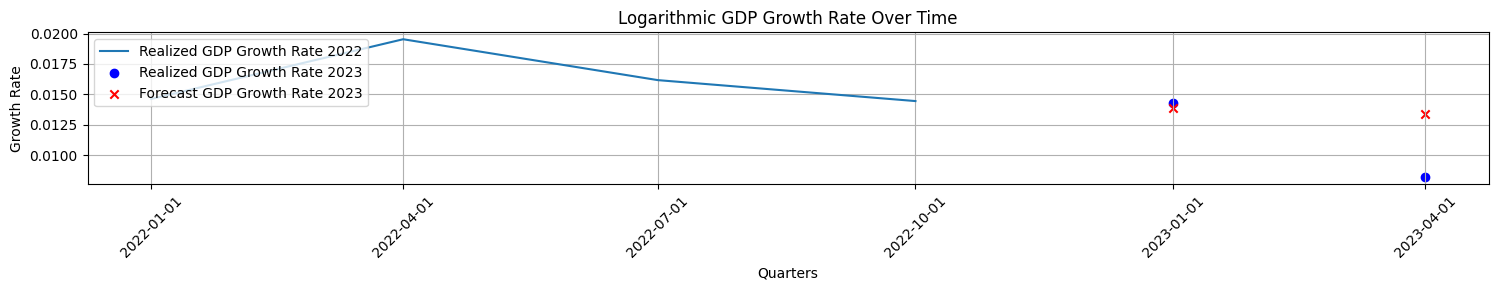

In [37]:
# Separating training and validation data based on the year
train = gdp[gdp['year'] <= 2022]
validation = gdp[gdp['year'] > 2022]

# Fit ARIMA(2,0,0) model on the training data
model = ARIMA(train['gdp_growth'].dropna(), order=(2,0,0)).fit()

# Generate forecast for the length of the validation set
forecasted_values = model.forecast(steps=len(validation))

# Add forecasted values to gdp DataFrame
gdp['forecasts_growth'] = forecasted_values

# Filter for 2022 data
filtered_gdp = gdp[(gdp['year'] >= 2022) & (gdp['year'] < 2023)]

# Plotting
plt.figure(figsize=(15, 3))
plt.plot(filtered_gdp.index, filtered_gdp["gdp_growth"], label="Realized GDP Growth Rate 2022")

# Filter for 2023 data
filtered_gdp1 = gdp[gdp['year'] >= 2023]

# Scatter plots for realized and forecast GDP growth rate for 2023
plt.scatter(filtered_gdp1.index, filtered_gdp1["gdp_growth"], color='blue', label="Realized GDP Growth Rate 2023")
plt.scatter(filtered_gdp1.index, filtered_gdp1['forecasts_growth'], color="red", marker='x', label="Forecast GDP Growth Rate 2023")

# Formatting and displaying the plot
plt.title("Logarithmic GDP Growth Rate Over Time")
plt.xlabel("Quarters")
plt.ylabel("Growth Rate")
plt.xticks(list(filtered_gdp.index) + list(filtered_gdp1.index), rotation=45)  # Rotate x-axis labels for readability
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Ljung-Box Test

In [38]:
# Ljung-Box Test

# To check the absence of autocorrelation in residuals at lag 10
ljung_box_statistic, ljung_box_pvalue = acorr_ljungbox(model.resid, lags=[10])
print(f'Ljung-Box test p-value: {ljung_box_pvalue[0]}')

# Display model summary which includes various statistics
print(model.summary())

Ljung-Box test p-value: l
                               SARIMAX Results                                
Dep. Variable:             gdp_growth   No. Observations:                  303
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 902.875
Date:                Mon, 16 Oct 2023   AIC                          -1797.751
Time:                        21:29:29   BIC                          -1782.896
Sample:                    04-01-1947   HQIC                         -1791.808
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.001      8.646      0.000       0.010       0.016
ar.L1          0.2123      0.028      7.583      0.000       0.157       0.267
ar.L2          0.2048     

### SARIMAX Results Analysis - Model Diagnostics

1. **Ljung-Box Test**: 
    - This test checks for autocorrelation of the residuals. Ideally, the residuals from a time series forecast model should not exhibit any patterns and should be white noise. 
    - The p-value is reported to be close to 1 (`Prob(Q) = 0.97`), suggesting that the residuals do not exhibit significant autocorrelations up to the lag considered (L1 in this case). This is a good sign for the model's adequacy.

2. **Jarque-Bera Test**:
    - This test checks if the residuals have a normal distribution. 
    - The p-value is reported to be 0 (`Prob(JB) = 0.00`), indicating that the residuals do not follow a normal distribution. However, it's important to note that while normality of residuals is a desirable property, many economic and financial time series models do produce non-normally distributed residuals, yet they can still be useful in forecasting.

3. **Heteroskedasticity Test**:
    - This test checks for changing variance within residuals.
    - The p-value is reported to be 0.04 (`Prob(H) = 0.04`), suggesting some evidence of heteroskedasticity. This might be a concern depending on the application, as homoskedastic residuals (constant variance) are a desirable property.

4. **Model Coefficients**:
    - The AR terms (`ar.L1` and `ar.L2`) have significant p-values (`P>|z|`), suggesting that they are statistically significant contributors to the model.

5. **Model Fit**:
    - The AIC, BIC, and HQIC are measures of the model's goodness of fit. Lower values indicate a better fit. However, these metrics are more useful when comparing multiple models.(For that we had already done)

### All in all

Given the Ljung-Box p-value suggests no significant autocorrelations in the residuals and the AR terms are statistically significant, the model seems reasonably adequate for forecasting. However, the non-normality and possible heteroskedasticity of residuals might be concerns, depending on the application.

Before making a final decision on using this model for forecasting, it might be beneficial to:
- Compare with other models or model configurations (e.g., different ARIMA orders).
- Consider potential transformations or methods to handle non-normality and heteroskedasticity.


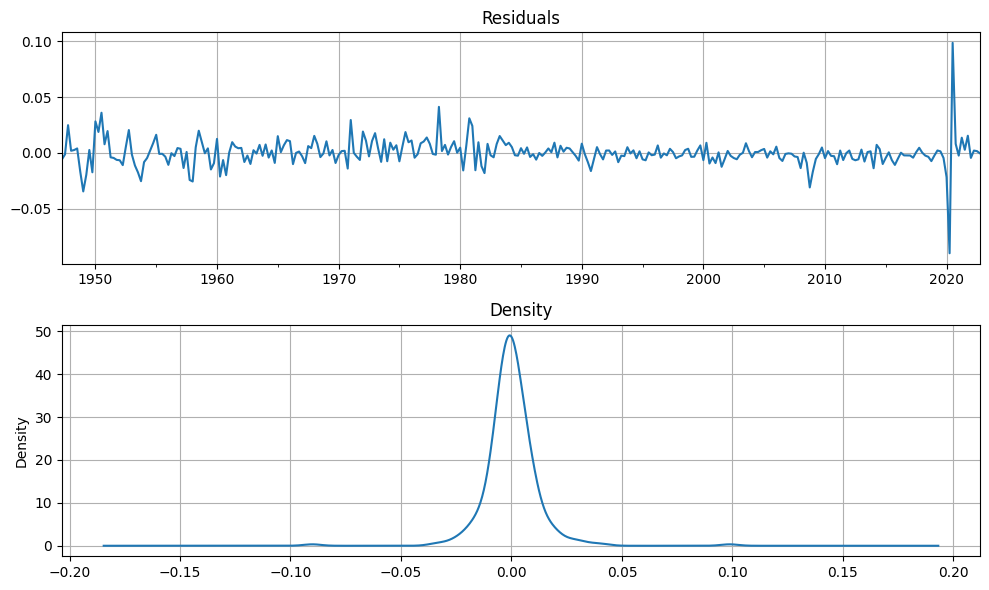

In [39]:
# Residual Analysis
plt.figure(figsize=(10,6))

# Residual Time Series Plot
plt.subplot(211)
model.resid.plot(title="Residuals")
plt.grid(True)

# Residual Density Plot
plt.subplot(212)
model.resid.plot(kind='kde', title='Density')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

### Residuals and Density Chart Explanation

#### Residuals:
- The residuals seem to be centered around zero for most of the period, suggesting that the model's predictions are, on average, accurate.
- However, there's a noticeable spike around 2020, indicating a significant deviation between the predicted and observed values.

#### Density:
- The peak of the density curve is close to zero, indicating that most residuals are near zero.
- The shape of the density plot suggests that the residuals are approximately normally distributed, which is a good sign for the adequacy of a time series model. However, some skewness might be present as the tail on the right is longer.


### **Final Thoughts**:
- Economic forecasting, especially GDP prediction, is complex. It requires a deep understanding of the underlying processes and often the interplay of various economic indicators.
- Always consider combining multiple models or ensemble methods for better accuracy.
- Engage domain experts and use their insights to guide and validate your forecasting efforts.
I hope this continues the content in a structured and comprehensive manner. Let me know if you have further questions or if there are specific sections you'd like me to expand upon!





